In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [2]:
from scipy.optimize import curve_fit


def f(t, a, b):
    return a * np.exp(b * t)

In [3]:
def graph_convergence(ax, algo_name, data, logscale, verbose=False, calc_gain=True):
    if verbose:
        print(f"*** Convergence of each param for {algo_name}")
        for c in range(data.shape[-1]):
            vars_popt, vars_pcov = curve_fit(f, data.index, data[c])
            print(
                f"{algo_name} PARAM: {c} -- Scale Factor: {vars_popt[0]}, Rate of Convergence: {vars_popt[1]}"
            )
        print()

    line_palette = ["r", "skyblue", "steelblue", "teal", "navy"]
    res = sns.lineplot(ax=ax, data=data, marker="o", lw=3, palette=line_palette)
    if logscale:
        res.set(xscale="log", yscale="log")
    ax.set_title(f"{algo_name}", fontsize=20)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.get_legend().remove()

    return ax

In [9]:
def simulate_algo(algo_name="Fisher", varX=True):
    variances_df = None
    gains_df = None

    fn_type = "labeled" if varX else "param_diff"
    col_name = "labels" if varX else "param_diffs"
    org_distr = pd.read_csv(f"../new_data/{algo_name}_{fn_type}.csv")

    org_distr[col_name] = org_distr[col_name].apply(
        lambda x: np.fromstring(
            x.replace("\n", "").replace("[", "").replace("]", "").replace("  ", " "),
            sep=" ",
        )
    )

    variances = []
    gains = []
    group_col = "realization" if varX else "Iteration"
    max_iter = max(org_distr['Iteration'].unique()) + 1
    
    if varX:
        for iters in range(20,max_iter,100): 
            grouped = org_distr[org_distr['Iteration'] < iters].groupby([group_col])
            mini_vars = []
            for (name, group) in grouped:
                diffs = group[col_name]
                algo_var = np.var(np.array(diffs), axis=0)
                mini_vars.append(algo_var)
            mean_var = np.mean(mini_vars)
            variances.append({'Algorithm':algo_name, 'Iteration': iters, 'Var(labeled_pts)':algo_var[1]})
    else:
        grouped = org_distr.groupby([group_col])
        for (name, group) in grouped:
            diffs = group[col_name]
            algo_var = np.var(np.array(diffs), axis=0)
            variances.append(algo_var)
    
    return pd.DataFrame(variances)

,Algorithm,Iteration,Var(labeled_pts),Gain,RandVar
0,AdjustedFisher,20,0.306811,0.167719,1.829317
1,AdjustedFisher,120,2.112923,NaN,NaN
2,AdjustedFisher,220,2.718307,NaN,NaN
3,AdjustedFisher,320,3.107752,NaN,NaN
4,AdjustedFisher,420,3.172448,NaN,NaN
...,...,...,...,...,...
95,AdjustedFisher,9520,3.436832,NaN,NaN
96,AdjustedFisher,9620,3.432711,NaN,NaN
97,AdjustedFisher,9720,3.430480,NaN,NaN
98,AdjustedFisher,9820,3.436784,NaN,NaN


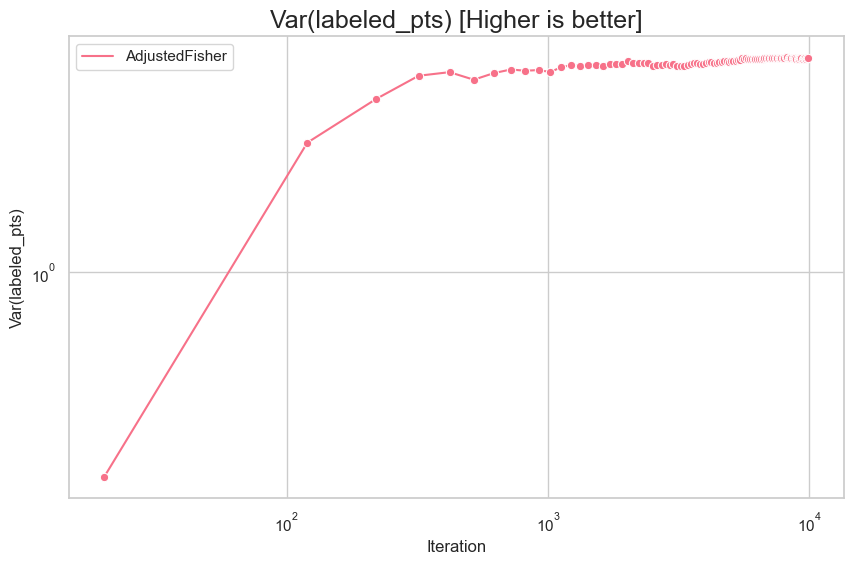

In [8]:
def plot_varx():
    algos = ["AdjustedFisher"]  #"CoreSet",, "BAIT" , "RandomSampling"
    variances_df = pd.DataFrame()
    for algo in algos:
        algo_var = simulate_algo(algo_name=algo, varX=True)
        rand_var = simulate_algo(algo_name="RandomSampling", varX=True)
        algo_var['Gain'] = algo_var['Var(labeled_pts)'] / rand_var['Var(labeled_pts)']
        algo_var['RandVar'] = rand_var['Var(labeled_pts)']
        variances_df = pd.concat([variances_df, algo_var], axis=0)
    variances_df = pd.DataFrame(variances_df).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xscale('log')
    ax.set_yscale('log')
    palette = sns.color_palette("husl", len(variances_df.Algorithm.unique()))
    sns.lineplot(data=variances_df, x='Iteration', y='Var(labeled_pts)', hue='Algorithm', palette=palette, marker='o')
    # add the annotation
    for i in ax.containers:
        ax.bar_label(i, fmt='Mean:\n%.2f', label_type='center', color='k', padding = 3)
    plt.title("Var(labeled_pts) [Higher is better]", size=18)
    plt.legend()
    return variances_df

plot_varx()

In [22]:
from collections import OrderedDict


def plot_param_sims(logscale=False, calc_gain=False, varX=False):
    figsz = (25, 6)
    algos = ["Fisher", "BAIT", "CoreSet", "Random"]  #

    fig, axes = plt.subplots(1, len(algos), figsize=figsz, sharex=True, sharey=True)
    fig.suptitle(
        f"{'Gain Ratio' if calc_gain else 'Variance'} on LinReg Model ({'higher' if calc_gain else 'lower'} is better)\n",
        size=30,
        y=1.12,
    )
    var_arg = r"Variance($x$)" if varX else r"Variance($\beta$-hat - $\beta$_true)"
    y_label = (
        r"Gain Ratio ($\frac{Var_{random}}{Var_{algo}}$) using " + var_arg
        if calc_gain
        else var_arg
    )

    fig.supylabel(y_label, size=20, x=0.07)
    fig.supxlabel("Iteration", size=20)

    for ax_indx, algo in enumerate(algos):
        variances_df = simulate_algo(algo, varX)
        graph_convergence(
            axes[ax_indx],
            algo,
            data=variances_df,
            logscale=logscale,
            calc_gain=calc_gain,
        )

    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [r"$\beta_" + str(l) + r"$" for l in labels]
    by_label = OrderedDict(zip(labels, handles))
    legend = fig.legend(
        by_label.values(),
        by_label.keys(),
        prop={"size": 20},
        bbox_to_anchor=(0.15, -0.2, 0.7, 0.102),
        ncol=2,  # 5,
        loc="lower left",
        mode="expand",
        borderaxespad=0.0,
    )
    legend.set_title("Parameters", prop={"size": 20})

    for i in range(len(labels)):
        legend.legend_handles[i].set_linewidth(6)

/var/folders/m7/lkv5b4cx1bvggq9mr7cs4vbr0000gp/T/ipykernel_10983/2962411390.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  res = sns.lineplot(ax=ax, data=data, marker="o", lw=3, palette=line_palette)
/var/folders/m7/lkv5b4cx1bvggq9mr7cs4vbr0000gp/T/ipykernel_10983/2962411390.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  res = sns.lineplot(ax=ax, data=data, marker="o", lw=3, palette=line_palette)
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/m7/lkv5b4cx1bvggq9mr7cs4vbr0000gp/T/ipykernel_10983/2962411390.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  res = sns.lineplot(ax=ax, data=data, marker="o", lw=3, palette=line_palette)
/Users/p/.virtualenvs/data_sci/lib/pyt

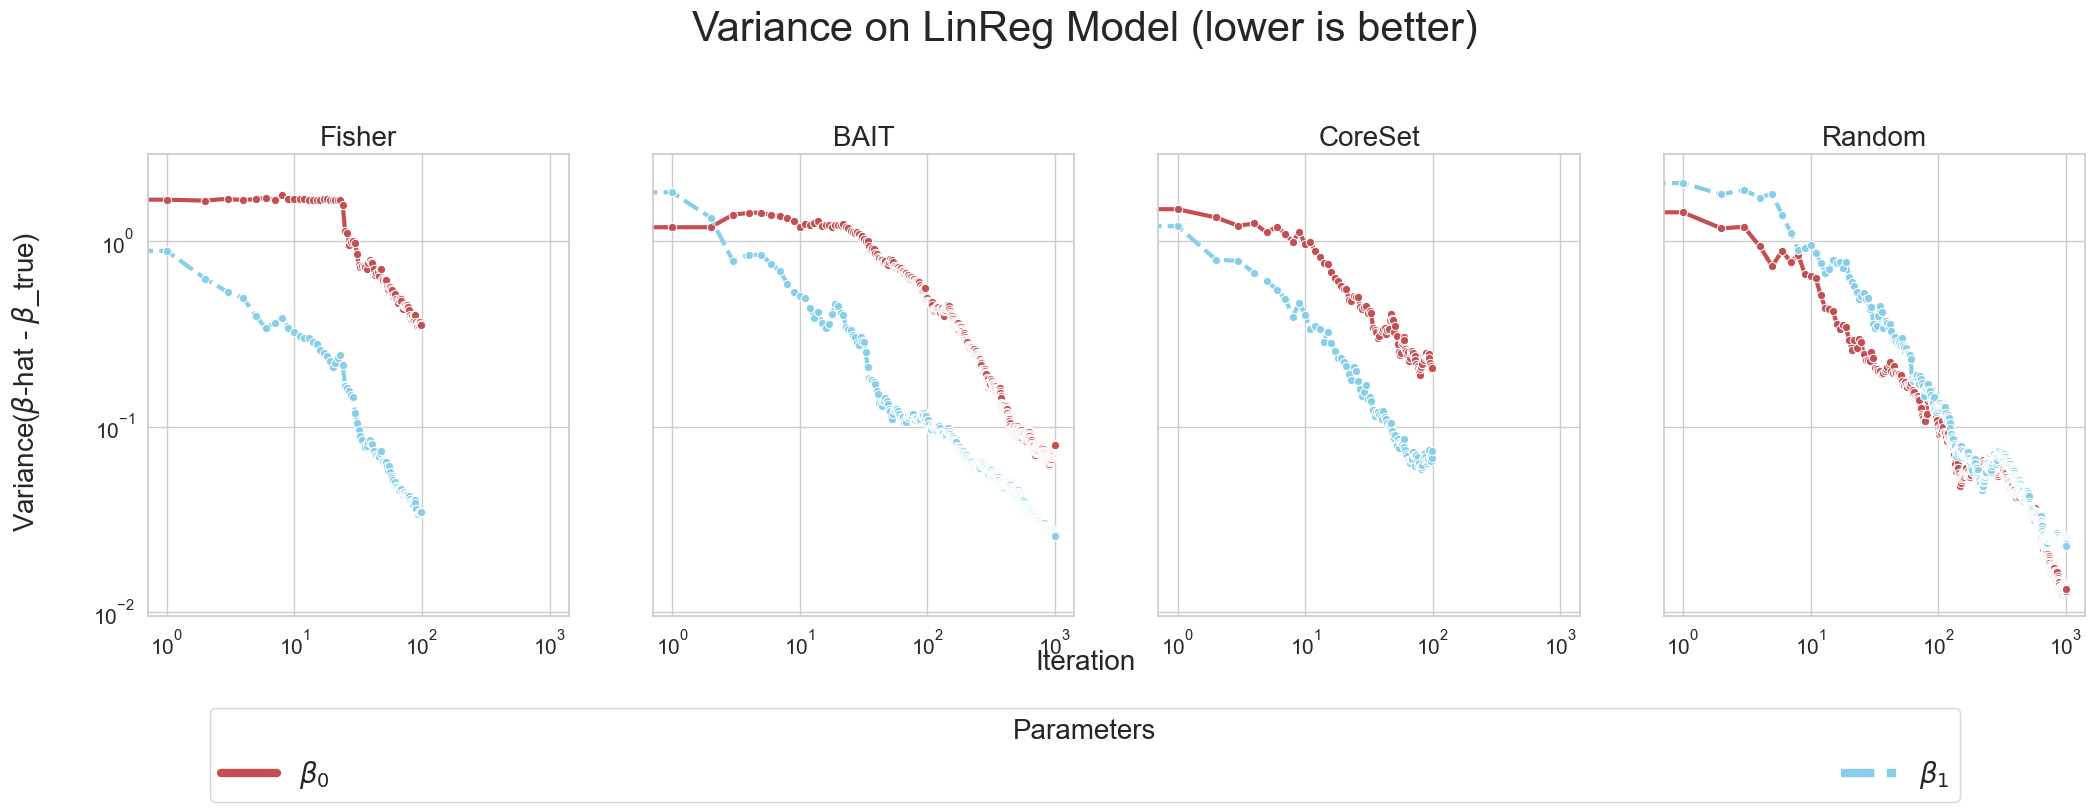

In [23]:
plot_param_sims(logscale=True)